# Monte Carlo simulations -  Analysis

In [1]:
#Go in the working directory
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd -q $workdir/

In [2]:
import os, json
import pandas as pd
import numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 100%; }
    div#maintoolbar-container { width: 100%; }
</style>
"""))

plt.rcParams.update({'font.size':16,'legend.frameon':True,'figure.figsize':[12,8],'xtick.major.size':7,'ytick.major.size':7,'legend.labelspacing':1})

# Functions

In [3]:
Na = 6.022e23

def Excess_pressure(jsonfile):
    with open(jsonfile) as f:
        d = json.load(f) # --> dict
        out = d["analysis"][5]['virtualvolume']['Pex/mM']
        return out
    
def Cl_conc(jsonfile):
    with open(jsonfile) as f:
        d = json.load(f) # --> dict
        if "density" in d["analysis"][1]:
            out = d["analysis"][1]['density']['atomic']['Cl']['c/M']
        else:
            out = d["analysis"][0]['density']['atomic']['Cl']['c/M']
        return out

# Solution conditions

In [4]:
###################################
pHs = {'pH2': { 'pH': [2],  'N':7},
       'pH5': { 'pH': [5],  'N':3},
      }
###################################

##########################################################################
Cp_range = [0.001, 0.002, 0.0040, 0.0070, 0.01, 0.015, 0.02, 0.025, 0.03]#
##########################################################################

# Extract the pressure cell boundary - One body - MC

In [5]:
# Load data if they exist 
if os.path.isfile('p_osm_cell.csv') and  os.path.isfile('p_osm_cell_ex.csv'):
    p_osm_cell = pd.read_csv('p_osm_cell.csv')
    p_osm_cell_ex = pd.read_csv('p_osm_cell_ex.csv')
    print('Data exist! Loaded!')

# Otherwise extract and save them
else:
    print('Data do not exist! Extracting ...')

    p_osm_cell = {}
    p_osm_cell_ex = {}

    for name, prop in pHs.items():
        p_osm_cell[str(name)] = {}
        p_osm_cell_ex[str(name)] = {}
        for pH in prop ['pH']:
            for Cp in Cp_range:
                path = '/One_body/'+str(name)+'/'+str(pH)+'/'+str(Cp)+'/'



                rho_Cl = np.loadtxt(workdir+path+'/Cl_profile.txt',unpack=True, usecols=(2))
                p_osm_cell[str(name)][Cp] = rho_Cl[-2] # This is in Molar
                p_osm_cell_ex[str(name)][Cp] = rho_Cl[-2]-prop['N'] * Cp # This is in Molar



    p_osm_cell = pd.DataFrame(p_osm_cell)
    p_osm_cell_ex = pd.DataFrame(p_osm_cell_ex)
    p_osm_cell.to_csv('p_osm_cell.csv')
    p_osm_cell_ex.to_csv('p_osm_cell_ex.csv')
    print(p_osm_cell)
    print(p_osm_cell_ex)

Data exist! Loaded!


# Extract the pressure from VVM - One Body

In [6]:
# Load data if they exist 
%cd -q $workdir/

if os.path.isfile('p_osm_cell_VVM.csv') and  os.path.isfile('p_osm_cell_VVM_ex.csv'):
    p_osm_cell_VVM = pd.read_csv('p_osm_cell_VVM.csv')
    p_osm_cell_VVM_ex = pd.read_csv('p_osm_cell_VVM_ex.csv')
    print('Data exist! Loaded!')

# Otherwise extract and save them
else:
    print('Data do not exist! Extracting ...')

    p_osm_cell_VVM = {}
    p_osm_cell_VVM_ex = {}

    for name, prop in pHs.items():
        p_osm_cell_VVM[str(name)] = {}
        p_osm_cell_VVM_ex[str(name)] = {}
        for pH in prop ['pH']:
            for Cp in Cp_range:
                path = '/One_body/'+str(name)+'/'+str(pH)+'/'+str(Cp)+'/'

                Z = prop['N']

                excess = Excess_pressure(workdir+path+'out.json')
                p_excess_cell_VVM = excess/1000 # /1000 to convert in Molar
                #print(excess)


                p_ideal_cell_VVM =  Z * Cp
                #p_ideal_cell_VVM =  Cl_conc(workdir+path+'out.json') # Equivalent to Z *Cp

                p_osm_cell_VVM[str(name)][Cp] = p_excess_cell_VVM + p_ideal_cell_VVM # This is in Molar
                p_osm_cell_VVM_ex[str(name)][Cp] = p_excess_cell_VVM # This is in Molar

    p_osm_cell_VVM = pd.DataFrame(p_osm_cell_VVM)
    p_osm_cell_VVM_ex = pd.DataFrame(p_osm_cell_VVM_ex)
    print(p_osm_cell_VVM) 
    print(p_osm_cell_VVM_ex)
    p_osm_cell_VVM.to_csv('p_osm_cell_VVM.csv')
    p_osm_cell_VVM_ex.to_csv('p_osm_cell_VVM_ex.csv')

Data exist! Loaded!


# Extract the pressure from VVM - Two Body

In [7]:
# Load data if they exist 
%cd -q $workdir/

if os.path.isfile('p_osm_cell_VVM_TB.csv') and  os.path.isfile('p_osm_cell_VVM_TB_ex.csv'):
    p_osm_cell_VVM_TB = pd.read_csv('p_osm_cell_VVM_TB.csv')
    p_osm_cell_VVM_TB_ex = pd.read_csv('p_osm_cell_VVM_TB_ex.csv')
    print('Data exist! Loaded!')

# Otherwise extract and save them
else:
    print('Data do not exist! Extracting ...')
    p_osm_cell_VVM_TB = {}
    p_osm_cell_VVM_TB_ex = {}

    for name, prop in pHs.items():
        p_osm_cell_VVM_TB[str(name)] = {}
        p_osm_cell_VVM_TB_ex[str(name)] = {}
        for pH in prop ['pH']:
            for Cp in Cp_range:
                path = '/Two_body/'+str(name)+'/'+str(pH)+'/'+str(Cp)+'/'

                Z = prop['N']
                #p_ideal_cell_VVM_TB =  Z * Cp
                p_ideal_cell_VVM_TB =  Cl_conc(workdir+path+'out.json') # Equivalent to Z * Cp        
                
                excess = Excess_pressure(workdir+path+'out.json')
                p_excess_cell_VVM_TB = excess/1000 # 1e27/Na is to convert from A^(-3) to Molar
               
                p_osm_cell_VVM_TB[str(name)][Cp] = p_excess_cell_VVM_TB + p_ideal_cell_VVM_TB # This is in Molar
                p_osm_cell_VVM_TB_ex[str(name)][Cp] = p_excess_cell_VVM_TB  # This is in Molar

    p_osm_cell_VVM_TB = pd.DataFrame(p_osm_cell_VVM_TB)
    p_osm_cell_VVM_TB_ex = pd.DataFrame(p_osm_cell_VVM_TB_ex)
    print(p_osm_cell_VVM_TB) 
    print(p_osm_cell_VVM_TB_ex) 
    p_osm_cell_VVM_TB.to_csv('p_osm_cell_VVM_TB.csv')
    p_osm_cell_VVM_TB_ex.to_csv('p_osm_cell_VVM_TB_ex.csv')

Data exist! Loaded!


# Pressure plot

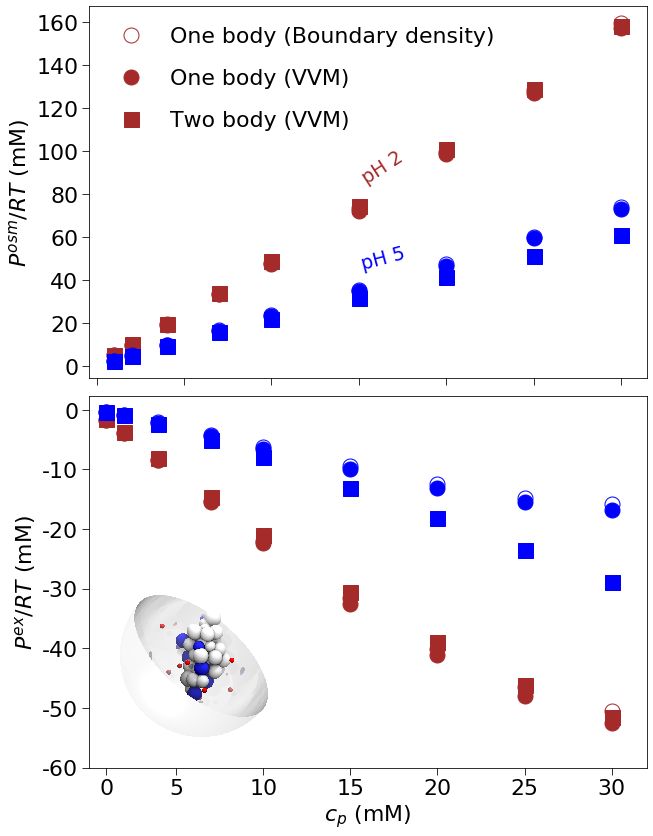

In [8]:
f = plt.figure(figsize=(10,14))
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.05)

fontsize = 22 

ax1 = f.add_subplot(211)
ax1.plot(Cp_range, p_osm_cell['pH2'], 'brown', marker='o',  markersize=15, linestyle=' ',markerfacecolor="None", alpha=1, label='One body (Boundary density)')
ax1.plot(Cp_range, p_osm_cell_VVM['pH2'], 'brown', marker='o', markersize=15, linestyle=' ', alpha=1, label='One body (VVM)')
ax1.plot(Cp_range, p_osm_cell_VVM_TB['pH2'], 'brown', marker='s', markersize=15, linestyle=' ', alpha=1, label='Two body (VVM)')

ax1.plot(Cp_range, p_osm_cell['pH5'], 'b', marker='o',  markersize=15, linestyle=' ', markerfacecolor="None", alpha=1)#, label='pH 5 - One body (Boundary density)')
ax1.plot(Cp_range, p_osm_cell_VVM['pH5'], 'b', marker='o', markersize=15, linestyle=' ', alpha=1)#, label='pH 5 - One body (VVM)')
ax1.plot(Cp_range, p_osm_cell_VVM_TB['pH5'], 'b', marker='s',  markersize=15, linestyle=' ', alpha=1)#, label='pH 5 - Two body (VVM)')

ax1.set_ylabel('$P^{osm}/RT$ (mM)', fontsize=fontsize)       
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1, yticks=[0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16], yticklabels=['0', '20', '40', '60', '80', '100', '120', '140', '160'] ) 

plt.legend(loc=2, frameon=0, fontsize=fontsize)
ax1.text(0.015, 0.085, r'pH 2', fontsize='large', color='brown', rotation=33)
ax1.text(0.015, 0.045, r'pH 5', fontsize='large', color='blue', rotation=15)

ax2 = f.add_subplot(212)
ax2.plot(Cp_range, p_osm_cell_ex['pH2'], 'brown', marker='o',  markersize=15, markerfacecolor="None", linestyle=' ', alpha=1)
ax2.plot(Cp_range, p_osm_cell_VVM_ex['pH2'], 'brown', marker='o', markersize=15, linestyle=' ', alpha=1)
ax2.plot(Cp_range, p_osm_cell_VVM_TB_ex['pH2'], 'brown', marker='s', markersize=15, linestyle=' ', alpha=1)

ax2.plot(Cp_range, p_osm_cell_ex['pH5'], 'b', marker='o',  markersize=15, markerfacecolor="None", linestyle=' ', alpha=1)
ax2.plot(Cp_range, p_osm_cell_VVM_ex['pH5'], 'b', marker='o', markersize=15, linestyle=' ', alpha=1)
ax2.plot(Cp_range, p_osm_cell_VVM_TB_ex['pH5'], 'b', marker='s',  markersize=15, linestyle=' ', alpha=1)
plt.setp(ax2, xticks=[0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030], xticklabels=['0', '5', '10', '15', '20', '25', '30'] ) 
plt.setp(ax2, yticks=[0, -0.01, -0.02, -0.03, -0.04, -0.05, -0.06], yticklabels=['0', '-10', '-20', '-30', '-40', '-50', '-60'] ) 
ax2.set_xlabel('$c_p$ (mM)', fontsize=fontsize)
ax2.set_ylabel('$P^{ex}/RT$ (mM)', fontsize=fontsize) 
ax2.set_xlim(0, 0.032)


#imgsize=180,180
#im1 = Image.open('fig.png')
#im1.thumbnail(imgsize, Image.ANTIALIAS)
#f.figimage(X=np.array(im1).astype(np.float)/255, xo=100, yo=70, resize=False, zorder=10)
cell_pic = mpimg.imread('fig.png')

imagebox = OffsetImage(cell_pic, zoom=0.15 )

ab = AnnotationBbox(imagebox, (0.006, -0.043), frameon=False)

ax2.add_artist(ab)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)
plt.savefig('MC_Pressure.png', frameone=True, bbox_inches='tight', dpi=300)